In [3]:
import keras
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [4]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

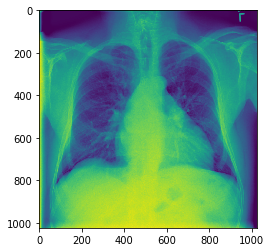

In [6]:
#Read in image files
file = "00000001_000.png"
test_tensor = img.imread(file)
plt.imshow(test_tensor)
plt.show()

In [7]:
test_tensor.size

1048576